# Random Forest Classifier for Object Exploration

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns # we will see in the next lesson
import matplotlib.pyplot as plt
import csv
import glob
import os
import cv2
import matplotlib.patches as patches
import math
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
import random

In [2]:
def multipoint_to_point_dist(xArray, yArray, pointCoord):
    from scipy.spatial import distance
    from numpy import stack
    xyCoord = np.stack((xArray, yArray), axis=1)
    dist = distance.cdist(xyCoord, pointCoord)

    return dist

In [3]:
#Opening all the .mp4(DLC-Analized) files in the specified directory (mp4 because DLC usuallyy creates mp4 files)
path = r'C:\Users\Francesca\Desktop\Lab\Esperimenti\DLC\Videos\DLC-AnalyzedVideos'
extension1 = 'mp4'
extension2 = 'csv'
os.chdir(path)
videos = glob.glob('*.{}'.format(extension1)) #list of all the videos
trackingFiles = glob.glob('*-filtered.{}'.format(extension2)) #list of the tracking files
EFIFiles = glob.glob('*-EFI.{}'.format(extension2)) #Collecting EFI(Exploration Frames Info) files

## Creation of a Training Dataset based on DLC-Analysed Videos
The training dataset is created using frame-by-frame manually labelled videos with:
- 0 = no object exploration
- 1 = object exploration

Analyzing video...030621-T2-ST1-Resnet50-iter15-snap8000
Arena selection done
Body coordinates remapped inside the arena
Body coordinates remapped to [0,1]
EFI File found
Analyzing video...030621-T2-ST2-Resnet50-iter15-snap8000
Arena selection done
Body coordinates remapped inside the arena
Body coordinates remapped to [0,1]
EFI File found
Analyzing video...030621-T4-TT-Resnet50-iter15-snap8000
Arena selection done
Body coordinates remapped inside the arena
Body coordinates remapped to [0,1]
EFI File found
Analyzing video...050721-T1-TT-Resnet50-iter15-snap8000
Arena selection done
Body coordinates remapped inside the arena
Body coordinates remapped to [0,1]
EFI File found
Analyzing video...050721-T2-TT-Resnet50-iter15-snap8000
Arena selection done
Body coordinates remapped inside the arena
Body coordinates remapped to [0,1]
EFI File found
Analyzing video...050721-T3-TT-Resnet50-iter15-snap8000
Arena selection done
Body coordinates remapped inside the arena
Body coordinates remapped to

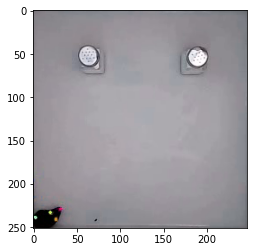

In [4]:
for i in range (len(videos)): #For every video in the directory

#############################
#     
    #OPEN THE CSV WITH TRACKING POSITIONS
    df = pd.read_csv(os.path.join(path, trackingFiles[i]), 
    header=[1,2], #setting the first 2 rows as column names
    dtype =np.float64, #defining the type of the objects inside the dataframe
    index_col=0
    ) #Take the first column as index by default


    #OPEN THE VIDEO FILE
    cap = cv2.VideoCapture(
    os.path.join(path, videos[i])
    ) 

    #SUBDIVIDE THE FILE NAME IN ORDER TO REMOVE THE .MP4 EXTENSION
    fileName = videos[i].split('.',2)
    
    print('Analyzing video...'+ fileName[0])

###############################
    #ARENA SELECTION BY USER
    try:
        
        numOfFrames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) #Tot frames
        chosenFrame = round(numOfFrames-300)# Choose the (lastFrame - 300) frame
        cap.set(cv2.CAP_PROP_POS_FRAMES,chosenFrame) #set the current frame as the random chosen frame
        _, chosenFrame = cap.read() # Read the frame
        roi=cv2.selectROI('Select the arena, then press space and enter', chosenFrame) #save the coordinates of the top left corner and the bottom right corner
        roi_cropped=chosenFrame[int(roi[1]):int(roi[1]+roi[3]), int(roi[0]):int(roi[0]+roi[2])]
        plt.imshow(roi_cropped)
        cv2.waitKey(0) # Wait until there is key input or automatically eliminate the window after 1000ms, 
        #0 means only use the key input to end the window
        cv2.destroyAllWindows()
        arenaSelection = input('Do you want to change your selection?[y/n]')
    
        while arenaSelection == 'y':
            roi=cv2.selectROI(chosenFrame) #save the coordinates of the top left corner and the bottom right corner
            roi_cropped=chosenFrame[int(roi[1]):int(roi[1]+roi[3]), int(roi[0]):int(roi[0]+roi[2])]
            plt.imshow(roi_cropped)
            cv2.waitKey(0) # Wait until there is key input or automatically eliminate the window after 1000ms, 
            #0 means only use the key input to end the window
            cv2.destroyAllWindows()
            arenaSelection = input('Do you want to change your selection?[y/n]')

        print('Arena selection done' )        

        #Selection of the object on the right
        obj1Roi = cv2.selectROI('Select the object on the right, then press space and enter', chosenFrame)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        ballSelection = input('Do you want to change your selection? [y/n]')
            
        while ballSelection == 'y':
            obj1Roi = cv2.selectROI('Select the object on the right, then press space and enter', chosenFrame)
            cv2.waitKey(0)
            cv2.destroyAllWindows()
            ballSelection = input('Do you want to change your selection? [y/n]')

        #Selection of the object on the left    
        obj2Roi = cv2.selectROI('Select the object on the left, then press space and enter', chosenFrame)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        saltSelection = input('Do you want to change your selection? [y/n]')
            
        while saltSelection == 'y':
            obj2Roi = cv2.selectROI('Select the object on the left, then press space and enter', chosenFrame)
            cv2.waitKey(0)
            cv2.destroyAllWindows()
            saltSelection = input('Do you want to change your selection? [y/n]')    
             
    except:
        print('An error occurred while getting a frame for the video.')

    finally:
        cap.release()  #I have to close the file

    

    #Making the selected arena a square arena
    arenaSide = (roi[2] + roi[3])/2 
    xThresholdLeft = roi[0]
    xThresholdRight = roi[0] + arenaSide
    yThresholdUp = roi[1]
    yThresholdDown = roi[1] + arenaSide

###########################################

    #REMAPPING BODY PARTS COORDINATES FALLING OUTSIDE THE ARENA
    bodyParts = df.keys()
    dfRemapped = df.copy()
    for ib in range(bodyParts.size): #For every tracked body part
        for ifr in range(dfRemapped.shape[0]): #For every frame
            if bodyParts[ib][1] == 'x':
                if dfRemapped[bodyParts[ib]][ifr] < xThresholdLeft:
                    dfRemapped[bodyParts[ib]][ifr] = xThresholdLeft
                if dfRemapped[bodyParts[ib]][ifr] > xThresholdRight:
                    dfRemapped[bodyParts[ib]][ifr] = xThresholdRight
                else:
                    if bodyParts[ib][1] == 'y':
                        if dfRemapped[bodyParts[ib]][ifr] < yThresholdUp:
                            dfRemapped[bodyParts[ib]][ifr] = yThresholdUp
                        if dfRemapped[bodyParts[ib]][ifr] > yThresholdDown:
                            dfRemapped[bodyParts[ib]][ifr] = yThresholdDown

    print('Body coordinates remapped inside the arena')

##############################################

    #SCALING BODY PART COORDINATES AND OBJECTS TO [0,1]

    ##Body parts coordinates
    dfScaled = dfRemapped.copy()
    for ib in range(bodyParts.size): #For every tracked body part
        if bodyParts[ib][1] == 'x':
            dfScaled[bodyParts[ib]] = (dfScaled[bodyParts[ib]] - roi[0])/arenaSide
        else:
            if bodyParts[ib][1] == 'y':
                dfScaled[bodyParts[ib]] = (dfScaled[bodyParts[ib]] - roi[1])/arenaSide

    ##Objects coordinates
    
    scaledObj1 = np.array([obj1Roi[0]-roi[0], obj1Roi[1]-roi[1], obj1Roi[2], obj1Roi[3]])
    scaledObj1 = scaledObj1/arenaSide
    scaledObj2 = np.array([obj2Roi[0]-roi[0], obj2Roi[1]-roi[1], obj2Roi[2], obj2Roi[3]])
    scaledObj2 = scaledObj2/arenaSide
    print('Body coordinates remapped to [0,1]')
    
#############################################
          
    #Csv containing information about the frames in which the mouse explores or not explores the objects (1 is the object on the right, 2 on the left)
    EFIName = fileName[0]+'-EFI.csv'
    if EFIName in EFIFiles:
        print('EFI File found')
        expFrameIndic = pd.read_csv(os.path.join(path,EFIName), 
        header=[0,1], #setting the first 2 rows as column names
        dtype ={('No_Exp','Start'):np.int64, ('No_Exp','Stop'):np.int64, ('Exp','Start'):np.int64, ('Exp','Stop'):np.int64,
        ('Object','Num'):np.int64, ('Video','Name'):str}, #defining the type of the objects inside the dataframe
        index_col=None) #Take the first column as index by default

        #Extracting body parts' positions from the originale dataframe and converting to np arrays
        xNose = dfScaled[bodyParts[0]].to_numpy()
        yNose = dfScaled[bodyParts[1]].to_numpy()   
        xOrDx = dfScaled[bodyParts[3]].to_numpy()
        yOrDx = dfScaled[bodyParts[4]].to_numpy()
        xOrSx = dfScaled[bodyParts[6]].to_numpy()
        yOrSx = dfScaled[bodyParts[7]].to_numpy()
        xCulo = dfScaled[bodyParts[9]].to_numpy()
        yCulo = dfScaled[bodyParts[10]].to_numpy()
        xCodaC = dfScaled[bodyParts[12]].to_numpy()
        yCodaC = dfScaled[bodyParts[13]].to_numpy()
        xCodaP = dfScaled[bodyParts[15]].to_numpy()
        yCodaP = dfScaled[bodyParts[16]].to_numpy()

        pointCoord1 = np.ndarray(shape = (1,2))
        pointCoord2 = np.ndarray(shape = (1,2))
        pointCoord1[0,0] = scaledObj1[0]+scaledObj1[2]/2 #Obj1 is the obj on the right
        pointCoord1[0,1] = scaledObj1[1]+scaledObj1[3]/2
        pointCoord2[0,0] = scaledObj2[0]+scaledObj2[2]/2 #Obj2 is the object on the left
        pointCoord2[0,1] = scaledObj2[1]+scaledObj2[3]/2

        obj1Radius = (scaledObj1[2] + scaledObj1[3])/4
        obj2Radius = (scaledObj2[2] + scaledObj2[3])/4


        #Dataframe containing all the distances from the objects(1 right, 2 left) and without the mouse tail
        distDf = {
        'noseD1': multipoint_to_point_dist(xNose, yNose, pointCoord1).flatten() - obj1Radius,
        'noseD2': multipoint_to_point_dist(xNose, yNose, pointCoord2).flatten() - obj2Radius,
        'orDxD1': multipoint_to_point_dist(xOrDx, yOrDx, pointCoord1).flatten() - obj1Radius,
        'orDxD2': multipoint_to_point_dist(xOrDx, yOrDx, pointCoord2).flatten() - obj2Radius,
        'orSxD1': multipoint_to_point_dist(xOrSx, yOrSx, pointCoord1).flatten() - obj1Radius,
        'orSxD2': multipoint_to_point_dist(xOrSx, yOrSx, pointCoord2).flatten() - obj2Radius,
        'culoD1': multipoint_to_point_dist(xCulo, yCulo, pointCoord1).flatten() - obj1Radius,
        'culoD2': multipoint_to_point_dist(xCulo, yCulo, pointCoord2).flatten() - obj2Radius,
        }
        distDf = pd.DataFrame.from_dict(distDf)

        df_x = distDf.iloc[int(expFrameIndic[('No_Exp','Start')][0]):][:]
        #df_y = np.zeros(df_x.shape[0]) #E' un dataframe tutto di 0
        arr = np.zeros(df_x.shape[0])
        dataDfy = {'labels':arr}
        df_y = pd.DataFrame(data=dataDfy)    
        for ik in range(expFrameIndic.shape[0]):
            for ic in range(int(expFrameIndic[('Exp', 'Start')][ik]), int(expFrameIndic[('Exp', 'Stop')][ik])+1):
                df_y.iloc[ic-int(expFrameIndic[('No_Exp','Start')][0])][0] = 1 #Converto in 1 i frame in cui c'è esplorazione

        suffixDist = fileName[0]+'-dist.csv'
        suffixTarget = fileName[0]+'-target.csv'
        csvDistName = os.path.join(path, suffixDist)
        df_x.to_csv(csvDistName,  index = False)
        #np.savetxt(suffixTarget, df_y, delimiter=",")
        df_y.to_csv(suffixTarget, index = False)
    else:
            print('No EFI file found')

## Random Forest Classifier

In [5]:
#Concatenate all the distance dataframes obtained from different videos
from sklearn.metrics import plot_confusion_matrix, classification_report
distFiles = glob.glob('*-dist.{}'.format(extension2)) #Collecting distance files
df1 = pd.read_csv(os.path.join(path, distFiles[0]), index_col=False) #Take the first column as index by default

for id in range(len(distFiles)-1):
    df2 = pd.read_csv(os.path.join(path, distFiles[id+1]),  index_col=False)
    frames = [df1, df2]
    df1 = pd.concat(frames)

df_x = df1

#Concatenate the target(those containing the 0 1 labels for exploration or not) dataframes
targetFiles = glob.glob('*-target.{}'.format(extension2)) #Collecting EFI(Exploration Frames Info) files
dft1 = pd.read_csv(os.path.join(path, targetFiles[0]), index_col=False) #Take the first column as index by default

for it in range(len(targetFiles)-1):
    dft2 = pd.read_csv(os.path.join(path, targetFiles[it+1]),  index_col=False)
    frames = [dft1, dft2]
    dft1 = pd.concat(frames)

df_y = dft1

#Training and testing datasets (stratified)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(df_x, df_y, test_size = 0.3, stratify = df_y, random_state = 1)

#Scaling
from sklearn.preprocessing import StandardScaler #for Scaling the features

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw) # computes std and mean of each feature and scaling. 
X_test  = scaler.transform(X_test_raw)  # scales the test data.

from sklearn.ensemble import RandomForestClassifier
# 1. instantiate model Random Forest with 50 decision trees
model = RandomForestClassifier(n_estimators=100,random_state=42, class_weight= 'balanced') 
# 2. fit model to data
model.fit(X_train, y_train)   
# 3. predict on new data
y_pred = model.predict(X_test)   
print('='*20,'Testing RANDOM FOREST Results','='*20)
print(classification_report(y_test, y_pred))
print('='*60)

<ipython-input-5-e2a807de39bf>:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


==================== Testing RANDOM FOREST Results ====================
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     41894
         1.0       0.95      0.93      0.94      2589

    accuracy                           0.99     44483
   macro avg       0.97      0.96      0.97     44483
weighted avg       0.99      0.99      0.99     44483



## Confusion Matrix

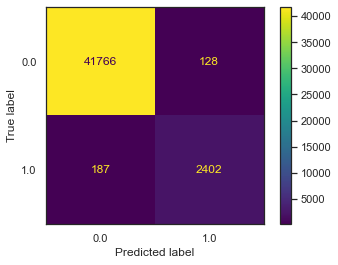

==================== Training Set Results ====================
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     97753
         1.0       1.00      1.00      1.00      6040

    accuracy                           1.00    103793
   macro avg       1.00      1.00      1.00    103793
weighted avg       1.00      1.00      1.00    103793

==================== Testing Set Results ====================
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     41894
         1.0       0.95      0.93      0.94      2589

    accuracy                           0.99     44483
   macro avg       0.97      0.96      0.97     44483
weighted avg       0.99      0.99      0.99     44483



In [6]:
from sklearn.metrics import plot_confusion_matrix, classification_report

sns.set(style="white")
plot_confusion_matrix(model, X_test, y_test) 
plt.show()

# Building a text report showing the main classification metrics.
print('='*20,'Training Set Results','='*20)
print(classification_report(y_train, model.predict(X_train)))

print('='*20,'Testing Set Results','='*20)
report_testing = classification_report(y_test, y_pred)
print(report_testing)
print('='*60)

# Predicting a New Video
1. Extrapolation of mouse labeled parts' distances from object1 and object2
2. Prediction of the New Video exploration frames by the pre-trained Random Forest Classifier

In [212]:
#Opening all the .mp4(DLC-Analized) files in the specified directory (mp4 because DLC usuallyy creates mp4 files)
newPath = r'C:\Users\Francesca\Desktop\Lab\Esperimenti\DLC\Videos\231121\T1-ST2'
extension1 = 'mp4'
extension2 = 'csv'
os.chdir(newPath)
newVideos = glob.glob('*.{}'.format(extension1)) #list of all the videos
newTrackingFiles = glob.glob('*-filtered.{}'.format(extension2)) #list of the tracking files

Analyzing video...231121-T1-ST2 DLC_resnet50_ChemogeneticsJul21shuffle1_5000_filtered_labeled
Arena selection done
Body coordinates remapped inside the arena
Body coordinates remapped to [0,1]


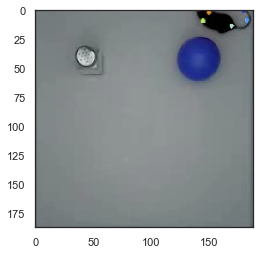

In [213]:
#PROCESSARE IL VIDEO
for i in range (len(newVideos)): #For every video in the directory

#############################
#     
    #OPEN THE CSV WITH TRACKING POSITIONS
    newDf = pd.read_csv(os.path.join(newPath, newTrackingFiles[i]), 
    header=[1,2], #setting the first 2 rows as column names
    dtype =np.float64, #defining the type of the objects inside the dataframe
    index_col=0
    ) #Take the first column as index by default


    #OPEN THE VIDEO FILE
    cap = cv2.VideoCapture(
    os.path.join(newPath, newVideos[i])
    ) 

    #SUBDIVIDE THE FILE NAME IN ORDER TO REMOVE THE .MP4 EXTENSION
    newFileName = newVideos[i].split('.',2)
    
    print('Analyzing video...'+ newFileName[0])

###############################

    #ARENA SELECTION BY USER
    try:
        
        newNumOfFrames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) #Tot frames
        newChosenFrame = round(newNumOfFrames-300)# Choose the (lastFrame - 300) frame
        cap.set(cv2.CAP_PROP_POS_FRAMES,newChosenFrame) #set the current frame as the random chosen frame
        _, newChosenFrame = cap.read() # Read the frame
        newRoi=cv2.selectROI('Select the arena, then press space and enter', newChosenFrame) #save the coordinates of the top left corner and the bottom right corner
        newCroppedRoi = newChosenFrame[int(newRoi[1]):int(newRoi[1]+newRoi[3]), int(newRoi[0]):int(newRoi[0]+newRoi[2])]
        plt.imshow(newCroppedRoi)
        cv2.waitKey(0) # Wait until there is key input or automatically eliminate the window after 1000ms, 
        #0 means only use the key input to end the window
        cv2.destroyAllWindows()
        arenaSelection = input('Do you want to change your selection?[y/n]')
    
        while arenaSelection == 'y':
            newRoi=cv2.selectROI(newChosenFrame) #save the coordinates of the top left corner and the bottom right corner
            newCroppedFrame=newChosenFrame[int(newRoi[1]):int(newRoi[1]+newRoi[3]), int(newRoi[0]):int(newRoi[0]+newRoi[2])]
            plt.imshow(newCroppedFrame)
            cv2.waitKey(0) # Wait until there is key input or automatically eliminate the window after 1000ms, 
            #0 means only use the key input to end the window
            cv2.destroyAllWindows()
            arenaSelection = input('Do you want to change your selection?[y/n]')

        print('Arena selection done' )        
    
        #Selection of the object on the right
        newObj1Roi = cv2.selectROI('Select the object on the right, then press space and enter', newChosenFrame)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        ballSelection = input('Do you want to change your selection? [y/n]')
            
        while ballSelection == 'y':
            newObj1Roi = cv2.selectROI('Select the object on the right, then press space and enter', newChosenFrame)
            cv2.waitKey(0)
            cv2.destroyAllWindows()
            ballSelection = input('Do you want to change your selection? [y/n]')

        #Selection of the object on the left    
        newObj2Roi = cv2.selectROI('Select the object on the left, then press space and enter', newChosenFrame)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        saltSelection = input('Do you want to change your selection? [y/n]')
        while saltSelection == 'y':
            newObj2Roi = cv2.selectROI('Select the object on the left, then press space and enter', newChosenFrame)
            cv2.waitKey(0)
            cv2.destroyAllWindows()
            saltSelection = input('Do you want to change your selection? [y/n]')    
             
    except:
        print('An error occurred while getting a frame for the video.')
    finally:
        cap.release()  #I have to close the file

    

    #Making the selected arena a square arena
    newArenaSide = (newRoi[2] + newRoi[3])/2 
    newXThresholdLeft = newRoi[0]
    newXThresholdRight = newRoi[0] + newArenaSide
    newYThresholdUp = newRoi[1]
    newYThresholdDown = newRoi[1] + newArenaSide

###########################################

    #REMAPPING BODY PARTS COORDINATES FOLLOWING OUTSIDE THE ARENA
    newBodyParts = newDf.keys()
    newDfRemapped = newDf.copy()
    for nib in range(newBodyParts.size): #For every tracked body part
        for nifr in range(newDfRemapped.shape[0]): #For every frame
            if newBodyParts[nib][1] == 'x':
                if newDfRemapped[newBodyParts[nib]][nifr] < newXThresholdLeft:
                    newDfRemapped[newBodyParts[nib]][nifr] = newXThresholdLeft
                if newDfRemapped[newBodyParts[nib]][nifr] > newXThresholdRight:
                    newDfRemapped[newBodyParts[nib]][nifr] = newXThresholdRight
                else:
                    if newBodyParts[nib][1] == 'y':
                        if newDfRemapped[newBodyParts[nib]][nifr] < newYThresholdUp:
                            newDfRemapped[newBodyParts[nib]][nifr] = newYThresholdUp
                        if newDfRemapped[newBodyParts[nib]][nifr] > newYThresholdDown:
                            newDfRemapped[newBodyParts[nib]][nifr] = newYThresholdDown
    
    print('Body coordinates remapped inside the arena')

##############################################

    #SCALING BODY PART COORDINATES AND OBJECTS TO [0,1]

    ##Body parts coordinates
    newDfScaled = newDfRemapped.copy()
    for nib in range(newBodyParts.size): #For every tracked body part
        if newBodyParts[nib][1] == 'x':
            newDfScaled[newBodyParts[nib]] = (newDfScaled[newBodyParts[nib]] - newRoi[0])/newArenaSide
        else:
            if newBodyParts[nib][1] == 'y':
                newDfScaled[newBodyParts[nib]] = (newDfScaled[newBodyParts[nib]] - newRoi[1])/newArenaSide

    ##Objects coordinates
    
    newScaledObj1 = np.array([newObj1Roi[0]-newRoi[0], newObj1Roi[1]-newRoi[1], newObj1Roi[2], newObj1Roi[3]])
    newScaledObj1 = newScaledObj1/newArenaSide
    newScaledObj2 = np.array([newObj2Roi[0]-newRoi[0], newObj2Roi[1]-newRoi[1], newObj2Roi[2], newObj2Roi[3]])
    newScaledObj2 = newScaledObj2/newArenaSide
    print('Body coordinates remapped to [0,1]')
    
    #Extracting body parts' positions from the originale dataframe and converting to np arrays
    newXNose = newDfScaled[newBodyParts[0]].to_numpy()
    newYNose = newDfScaled[newBodyParts[1]].to_numpy()   
    newXOrDx = newDfScaled[newBodyParts[3]].to_numpy()
    newYOrDx = newDfScaled[newBodyParts[4]].to_numpy()
    newXOrSx = newDfScaled[newBodyParts[6]].to_numpy()
    newYOrSx = newDfScaled[newBodyParts[7]].to_numpy()
    newXCulo = newDfScaled[newBodyParts[9]].to_numpy()
    newYCulo = newDfScaled[newBodyParts[10]].to_numpy()
    newXCodaC = newDfScaled[newBodyParts[12]].to_numpy()
    newYCodaC = newDfScaled[newBodyParts[13]].to_numpy()
    newXCodaP = newDfScaled[newBodyParts[15]].to_numpy()
    newYCodaP = newDfScaled[newBodyParts[16]].to_numpy()

    newPointCoord1 = np.ndarray(shape = (1,2))
    newPointCoord2 = np.ndarray(shape = (1,2))
    newPointCoord1[0,0] = newScaledObj1[0]+newScaledObj1[2]/2 #Obj1 is the obj on the right
    newPointCoord1[0,1] = newScaledObj1[1]+newScaledObj1[3]/2
    newPointCoord2[0,0] = newScaledObj2[0]+newScaledObj2[2]/2 #Obj2 is the object on the left
    newPointCoord2[0,1] = newScaledObj2[1]+newScaledObj2[3]/2

    newObj1Radius = (newScaledObj1[2] + newScaledObj1[3])/4
    newObj2Radius = (newScaledObj2[2] + newScaledObj2[3])/4

    #Dataframe containing all the distances from the objects(1 right, 2 left) and without the mouse tail
    newDistDf = {
    'noseD1': multipoint_to_point_dist(newXNose, newYNose, newPointCoord1).flatten() - newObj1Radius,
    'noseD2': multipoint_to_point_dist(newXNose, newYNose, newPointCoord2).flatten() - newObj2Radius,
    'orDxD1': multipoint_to_point_dist(newXOrDx, newYOrDx, newPointCoord1).flatten() - newObj1Radius,
    'orDxD2': multipoint_to_point_dist(newXOrDx, newYOrDx, newPointCoord2).flatten() - newObj2Radius,
    'orSxD1': multipoint_to_point_dist(newXOrSx, newYOrSx, newPointCoord1).flatten() - newObj1Radius,
    'orSxD2': multipoint_to_point_dist(newXOrSx, newYOrSx, newPointCoord2).flatten() - newObj2Radius,
    'culoD1': multipoint_to_point_dist(newXCulo, newYCulo, newPointCoord1).flatten() - newObj1Radius,
    'culoD2': multipoint_to_point_dist(newXCulo, newYCulo, newPointCoord2).flatten() - newObj2Radius,
    }
    newDistDf = pd.DataFrame.from_dict(newDistDf)

    newExpFrameIndic = int(input('Insert the starting frame'))

    newDf_x = newDistDf.iloc[newExpFrameIndic:][:]
    suffixDist = newFileName[0]+'-dist.csv'
    csvDistName = os.path.join(newPath, suffixDist)
    newDf_x.to_csv(csvDistName,  index = False)

0.09795918367346938


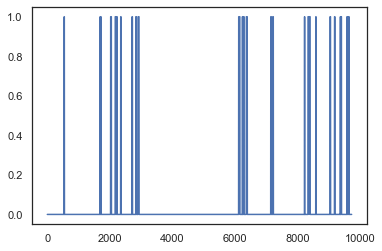

In [214]:
# New Video Prediction by the Random Forest Classifier
X_data = newDf_x.to_numpy()
X_t = scaler.transform(X_data)
y_pred = model.predict(X_t)   

fps = 25
obj1Frames = 0
obj2Frames = 0
for nFrames in range(y_pred.shape[0]):
    if X_t[nFrames][0] < X_t[nFrames][1]:
        obj1Frames = obj1Frames + y_pred[nFrames]
    else:
        obj2Frames = obj2Frames + y_pred[nFrames]    

obj1Time = obj1Frames/fps
obj2Time = obj2Frames/fps
predDI = (obj1Time - obj2Time)/(obj1Time + obj2Time)
plt.plot(y_pred)
print(predDI)

# Comparing Random Forest Prediction with Experimenter Prediction

In [216]:
# Opening the csv file containing experimenter prediction
expPath = r'C:\Users\Francesca\Desktop\Lab\Esperimenti\DLC\Videos\231121\T1-ST2'
extension1 = 'mp4'
extension2 = 'csv'
os.chdir(expPath)
expVideos = glob.glob('*.{}'.format(extension1)) #list of all the videos
expTrackingFiles = glob.glob('*-EFI.{}'.format(extension2)) #list of the tracking files

exp_df = pd.read_csv(os.path.join(expPath, expTrackingFiles[0]), 
header=[0,1], #setting the first 2 rows as column names
dtype ={('No_Exp','Start'):np.int64, ('No_Exp','Stop'):np.int64, ('Exp','Start'):np.int64, ('Exp','Stop'):np.int64,
('Object','Num'):np.int64, ('Video','Name'):str}, #defining the type of the objects inside the dataframe
index_col=None) #Take the first column as index by default


### Creating the exp_y vector containing experimenter labels

In [217]:
arr = np.zeros(newDf_x.shape[0])
dataDfy = {'labels':arr}
exp_y = pd.DataFrame(data=dataDfy)    
for ik in range(exp_df.shape[0]):
    for ic in range(int(exp_df[('Exp', 'Start')][ik]), int(exp_df[('Exp', 'Stop')][ik])+1):
        exp_y.iloc[ic-int(exp_df[('No_Exp','Start')][0])][0] = 1 #Converto in 1 i frame in cui c'è esplorazione


In [47]:
ic = 0
range(int(exp_df[('Exp', 'Start')][ik]), int(exp_df[('Exp', 'Stop')][ik])+1)

range(8525, 8530)

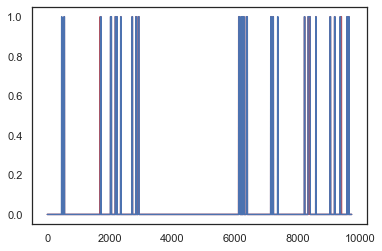

In [218]:
plt.plot(y_pred, 'r')
plt.plot(exp_y, 'b')

In [219]:
fps = 25
RFObj1Frames = 0
RFObj2Frames = 0
EObj1Frames = 0
EObj2Frames = 0

# Random Forest Prediction
for nFrames in range(y_pred.shape[0]):
    if X_t[nFrames][0] < X_t[nFrames][1]:
        RFObj1Frames = RFObj1Frames + y_pred[nFrames]
    else:
        RFObj2Frames = RFObj2Frames + y_pred[nFrames]    

RFObj1Time = RFObj1Frames/fps
RFObj2Time = RFObj2Frames/fps
RFDI1vs2 = (RFObj1Time - RFObj2Time)/(RFObj1Time + RFObj2Time)


# Experimenter classification
for eFrames in range(exp_y.shape[0]):
    if X_t[eFrames][0] < X_t[eFrames][1]:
        EObj1Frames = EObj1Frames + exp_y.iloc[eFrames]
    else:
        EObj2Frames = EObj2Frames + exp_y.iloc[eFrames]    

EObj1Time = EObj1Frames/fps
EObj2Time = EObj2Frames/fps
EDI1vs2 = (EObj1Time-EObj2Time)/(EObj1Time+EObj2Time)

print(RFDI1vs2, EDI1vs2)

0.09795918367346938 labels    0.160075
dtype: float64


# Behavioral Scoring Based on Nose-Object Distance

In [220]:
#newDf_x is the dataFrame containing the distances from the objects
fps = 25
newDf_x.reset_index(inplace=True)
NOArr = np.zeros(newDf_x.shape[0])
NODataDfy = {'labels':NOArr}
NO_y = pd.DataFrame(data=NODataDfy)
objDist = range(0,105,5)
logObjDist = np.logspace(-3, 0.15, 40)


NOObj1Frames = np.zeros(len(logObjDist))
NOObj2Frames = np.zeros(len(logObjDist))
expFrames = np.zeros((newDf_x.shape[0], len(logObjDist)), dtype=int)

# Per ogni frame
for ik in range(newDf_x.shape[0]):
    for trial in range(len(logObjDist)): #per ogni distanza
        if newDf_x['noseD1'][ik] <= logObjDist[trial]:
            NOObj1Frames[trial] = NOObj1Frames[trial] + 1
            expFrames[ik, trial] = 1

        if newDf_x['noseD2'][ik] <= logObjDist[trial]:
            NOObj2Frames[trial] = NOObj2Frames[trial] + 1
            expFrames[ik, trial] = 1
    


NODI = np.zeros(len(logObjDist))
for trial in range(len(logObjDist)):
    if NOObj1Frames[trial]==0 or NOObj2Frames[trial] == 0:
        NODI[trial] = 0
    else:
        NODI[trial] = (NOObj1Frames[trial]/fps - NOObj2Frames[trial]/fps)/(NOObj1Frames[trial]/fps + NOObj2Frames[trial]/fps)


# La mia arena è 40 cm di lato, i punti vanno da 0 a 1
realDist = np.zeros(len(logObjDist))
for j in range(len(logObjDist)):
    realDist[j] = 40*logObjDist[j]

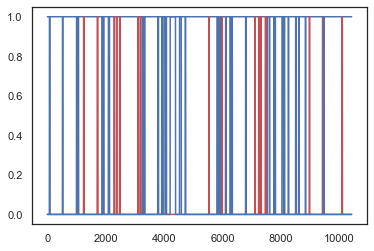

In [21]:
plt.plot(expFrames[:,1], 'b')
plt.plot(y_pred, 'r')
plt.plot(exp_y, 'b')

In [89]:
import math
math.log10(math.sqrt(2))

0.15051499783199063

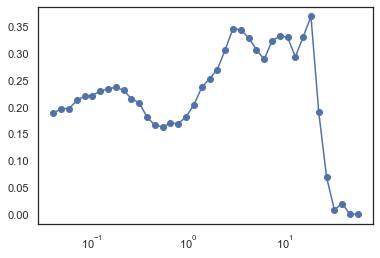

In [221]:
%matplotlib inline
plt.semilogx(realDist, NODI, marker='o')


In [94]:
realDist

array([4.00000000e-02, 4.81758318e-02, 5.80227693e-02, 6.98823794e-02,
       8.41660439e-02, 1.01369229e-01, 1.22088674e-01, 1.47043085e-01,
       1.77098074e-01, 2.13296175e-01, 2.56893017e-01, 3.09400869e-01,
       3.72641106e-01, 4.48807382e-01, 5.40541724e-01, 6.51026179e-01,
       7.84093193e-01, 9.44358545e-01, 1.13738146e+00, 1.36985745e+00,
       1.64985055e+00, 1.98707307e+00, 2.39322245e+00, 2.88238706e+00,
       3.47153485e+00, 4.18110198e+00, 5.03570165e+00, 6.06497789e+00,
       7.30463387e+00, 8.79767033e+00, 1.05958772e+01, 1.27616299e+01,
       1.53700534e+01, 1.85116277e+01, 2.22953265e+01, 2.68523975e+01,
       3.23409147e+01, 3.89512617e+01, 4.69127358e+01, 5.65015018e+01])

In [222]:
NODI-0.16

array([ 0.0284058 ,  0.03713262,  0.03713262,  0.05254355,  0.06068966,
        0.06147651,  0.07026316,  0.07376623,  0.07717949,  0.07125   ,
        0.05556886,  0.04809249,  0.0210585 ,  0.00622691,  0.00290727,
        0.00990291,  0.00901408,  0.02202247,  0.04416667,  0.07664122,
        0.09314183,  0.1100491 ,  0.14659026,  0.18601665,  0.18465534,
        0.16929991,  0.14752374,  0.12914141,  0.16315522,  0.17278008,
        0.17055845,  0.13389671,  0.17121357,  0.20923077,  0.03038668,
       -0.09093898, -0.15147814, -0.14020905, -0.16      , -0.16      ])

In [520]:
NODI+0.62



array([ 2.13220339e-01, -1.73103448e-01, -7.06369240e-02, -2.02911337e-04,
        5.76944190e-02,  1.00778749e-01,  1.14991524e-01,  1.26059279e-01,
        1.22529050e-01,  1.38180633e-01,  1.68522167e-01,  2.89440888e-01,
        3.87497692e-01,  5.00984305e-01,  5.40024971e-01,  5.65765230e-01,
        5.89021066e-01,  5.97737185e-01,  5.92276238e-01,  5.98730366e-01,
        6.10931399e-01])

In [181]:
len(NOArr)

7810

In [171]:
abs(NODI+0.26)


array([0.07632653, 0.07596452, 0.22937698, 0.30201681, 0.30347826,
       0.256875  , 0.25438017, 0.26716846, 0.31681818, 0.35163149,
       0.37016379, 0.31962459, 0.3109009 , 0.27974266, 0.27372404,
       0.27732871, 0.2763333 , 0.25778479, 0.2629456 , 0.26278804])